In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from itertools import chain

import spacy
spacy.cli.download("en_core_web_sm")

#import gender_guesser.detector as gender

from allennlp.predictors.predictor import Predictor
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


ModuleNotFoundError: No module named 'allennlp'

In [2]:
#Load data and set indexes
movie_metadata = pd.read_csv("movie.metadata.tsv", sep='\t', header = None)
movie_metadata.columns = ['movie_ID','FB_ID','movie_name','release_date','box_office','length','languages','country','genres']

#Force float type to the movie ID column, set as index
movie_metadata.movie_ID = movie_metadata.movie_ID.astype(int)
movie_metadata = movie_metadata.set_index('movie_ID')

#Drop freebase database ID, we don't need it
movie_metadata = movie_metadata.drop(columns=['FB_ID'])

#Remove movies with non-defined release date
#Convert release date to datetime type, only keep year 
movie_metadata = movie_metadata[movie_metadata.release_date.notna()]
movie_metadata['release_date'] = movie_metadata.release_date.apply(lambda d:datetime.strptime(str(d[0:4]), "%Y"))
movie_metadata['release_date'] = [date.year for date in movie_metadata.release_date]

#Change release date 1010, it's a mistake movie actually release in 2010
movie_metadata = movie_metadata.replace(1010,2010)

#Clean languages, country, genres columns
movie_metadata['languages'] = [lang.split('"')[3::4] for lang in movie_metadata.languages]
movie_metadata['country'] = [lang.split('"')[3::4] for lang in movie_metadata.country]
movie_metadata['genres'] = [lang.split('"')[3::4] for lang in movie_metadata.genres]

movie_metadata.head(3)

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"


In [59]:
#Load character metadata (code Alexia)
character_metadata = pd.read_csv("character.metadata.tsv", sep='\t', header=None)

#only keep movie_ID , name, gender, and age
character_metadata = character_metadata.iloc[:,[0,2,3,5,9]]  # Need to add release date in Alexia code
character_metadata.columns = ['movie_ID','release_date','name','gender','age']
character_metadata.name = character_metadata['name'].astype(str)
character_metadata.movie_ID = character_metadata['movie_ID'].astype(int)
character_metadata = character_metadata.set_index('movie_ID')

#Drop the characters without gender defined
character_metadata = character_metadata[character_metadata.gender.notna()]

character_metadata.head(3)

,release_date,name,gender,age
movie_ID,,,,
975900,2001-08-24,Akooshay,F,42.0
975900,2001-08-24,Lieutenant Melanie Ballard,F,27.0
975900,2001-08-24,Desolation Williams,M,32.0


In [60]:
character_metadata = character_metadata[character_metadata['release_date'].notna()]
character_metadata['release_date'] = character_metadata['release_date'].apply(lambda x : datetime.strptime(str(x)[0:4],"%Y")) #keeping only the year
character_metadata['release_date'] = [date.year for date in character_metadata['release_date']]  #Expliquer pourquoi on garde que l'année
character_metadata = character_metadata.replace(1010, 2010)
character_metadata.head(2)

,release_date,name,gender,age
movie_ID,,,,
975900,2001,Akooshay,F,42.0
975900,2001,Lieutenant Melanie Ballard,F,27.0


**Mon code à partir de là:**

In [61]:
#Joining movie and character metadata
merged_charac = pd.merge(left = character_metadata, right = movie_metadata['genres'], on = 'movie_ID', how = 'left')
merged_charac.head(3)

,release_date,name,gender,age,genres
movie_ID,,,,,
975900,2001,Akooshay,F,42.0,"[Thriller, Science Fiction, Horror, Adventure,..."
975900,2001,Lieutenant Melanie Ballard,F,27.0,"[Thriller, Science Fiction, Horror, Adventure,..."
975900,2001,Desolation Williams,M,32.0,"[Thriller, Science Fiction, Horror, Adventure,..."


In [62]:
#Taking first genre mentionned as main genre, ignoring rows with no genre
merged_charac['Main genre'] = merged_charac['genres'].apply(lambda x :x[0] if (x != []) else None) 

In [64]:
#Separating dataframe based on character gender
characters_F = merged_charac[merged_charac['gender'] == 'F']
characters_M = merged_charac[merged_charac['gender'] == 'M']

Nb_charac_F = characters_F.groupby('release_date').count()
Nb_charac_M = characters_M.groupby('release_date').count()
Nb_charac_M.head(3)

,name,gender,age,genres,Main genre
release_date,,,,,
1888,2,2,0,2,2
1891,1,1,0,1,1
1893,2,2,0,2,2


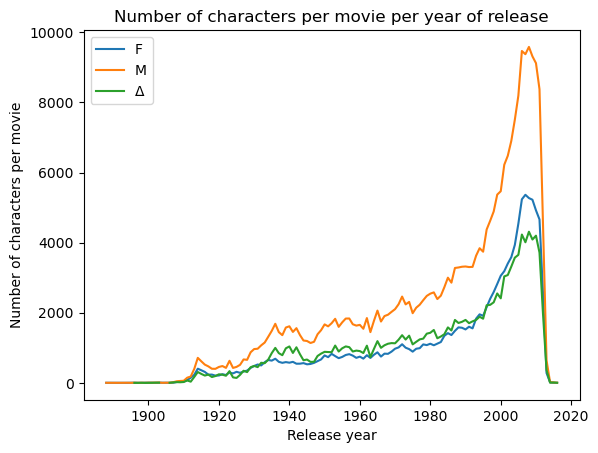

In [7]:
plt.plot(Nb_charac_F['name'], label = 'F')
plt.plot(Nb_charac_M['name'], label = 'M')
plt.plot(Nb_charac_M['name'] - Nb_charac_F['name'], label = '\u0394')
plt.title('Number of characters per movie per year of release')
plt.xlabel('Release year')
plt.ylabel('Number of characters per movie')
plt.legend()
plt.show()

In [65]:
#Counting and sorting genres of movies in which male/female characters appear
F_genre = characters_F.groupby('Main genre').count()
M_genre = characters_M.groupby('Main genre').count()

F_genre = F_genre.sort_values('name', axis = 0, ascending = False)
M_genre = M_genre.sort_values('name', axis = 0, ascending = False)

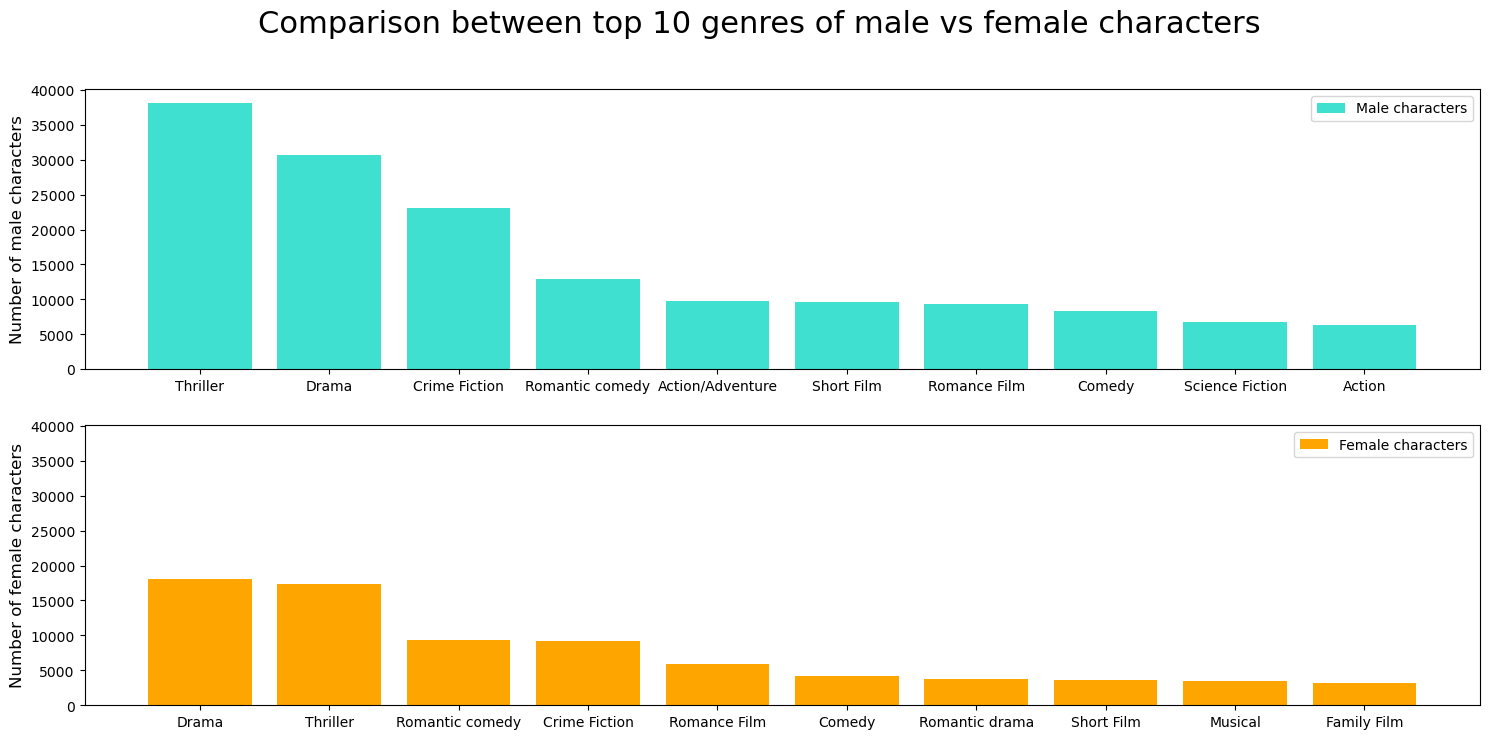

In [66]:
#Plotting top 10 genres in which male/female characters are "famous"
fig, ax = plt.subplots(2,1, figsize = (18,8), sharey = True) 

ax[0].bar(M_genre.index[0:10], M_genre['name'][0:10], label = 'Male characters', color = 'turquoise')
ax[0].legend()
ax[0].set_ylabel('Number of male characters', fontsize = 12)

ax[1].bar(F_genre.index[0:10], F_genre['name'][0:10], label = 'Female characters', color = 'orange')
ax[1].legend()
ax[1].set_ylabel('Number of female characters', fontsize = 12)
    
fig.suptitle('Comparison between top 10 genres of male vs female characters', fontsize = 22)
plt.show()

In this plot, we observe that the top 10 genres in terms of characters' appearances are different between men and women. We notice that some genres are shared such as drama, thriller and romantic comdey but others are completely absent for a certain gender. Additionally, some of the genres are very stereotypical for each gender. For example, 5 out of 10 genres for female characters are related to family, romance or music whereas male characters are much more present in action science fiction movies.

We wanted to focus on the evolution of the number of female and male characters in a few stereotypical genre of movies through time and see if the difference tends to decrease. For that, we chose "Action/Adventure" and "Family Film".

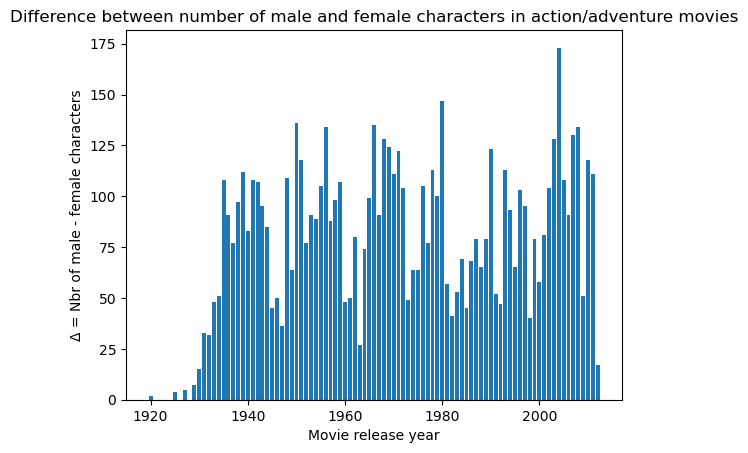

In [114]:
#Mask with only movies which have 'Action/Adventure' as main genre and grouping by year
M_action_adv = characters_M[characters_M['Main genre'] == 'Action/Adventure']
M_action_adv_year = M_drama.groupby('release_date').count()

F_action_adv = characters_F[characters_F['Main genre'] == 'Action/Adventure']
F_action_adv_year = F_action_adv.groupby('release_date').count()

diff_action_adv =  M_action_adv_year['name'] - F_action_adv_year['name']

#Plotting differene between nbr of male vs female characters in 'Action/Adventure' movie through time
plt.bar(diff_action_adv.index, diff_action_adv)
plt.xlabel('Movie release year')
plt.ylabel('\u0394 = Nbr of male - female characters')
plt.title('Difference between number of male and female characters in action/adventure movies')
plt.show()

In a general manner, we observe a sort of constant trend with oscillations. By comparing between the early and final of the dataset, we see no clear increase which would mean that female characters are not necessarily more present in the latest action/adventure movies.

Explanation for big drops ??

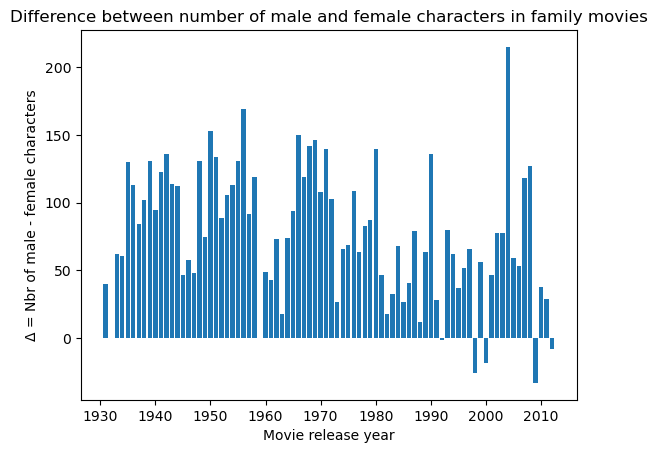

In [118]:
M_family = characters_M[characters_M['Main genre'] == 'Family Film']
M_family_year = M_drama.groupby('release_date').count()

F_family = characters_F[characters_F['Main genre'] == 'Family Film']
F_family_year = F_action_adv.groupby('release_date').count()

diff_family =  M_family_year['name'] - F_family_year['name']
diff_family.fillna(0) #For some years, one of the two genders has 0 characters in this genre of movie
#F_action_adv_year.sum()

plt.bar(diff_family.index, diff_family)
plt.xlabel('Movie release year')
plt.ylabel('\u0394 = Nbr of male - female characters')
plt.title('Difference between number of male and female characters in family movies')
plt.show()

Very surprisingly, even in family films where it is expected that female characters are very important and maybe even more present than men, it is not the case! There is (almost) are much more male characters. With time, a small decrease of this difference seems to arise.

**CODE BREAK**

In [10]:
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False) 

F_count_genre = get_count_genre(characters_F.genres)
M_count_genre = get_count_genre(characters_M.genres)

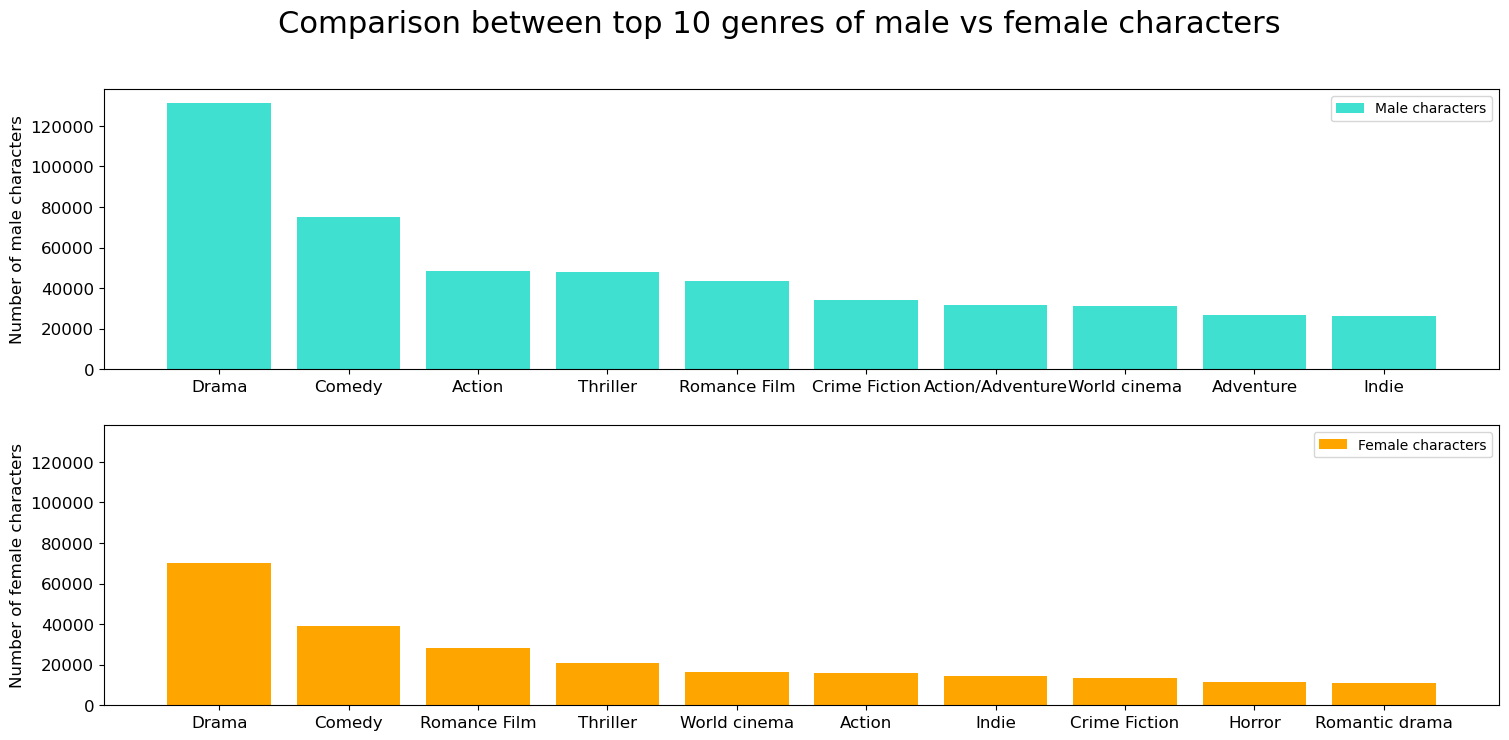

In [38]:
fig, ax = plt.subplots(2,1, figsize = (18,8), sharey = True)   #share x ??

ax[0].bar(M_count_genre.genre[0:10], M_count_genre['count'][0:10], label = 'Male characters', color = 'turquoise')
ax[0].legend()
ax[0].set_ylabel('Number of male characters', fontsize = 12)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(12)

ax[1].bar(F_count_genre.genre[0:10], F_count_genre['count'][0:10], label = 'Female characters', color = 'orange')
ax[1].legend()
ax[1].set_ylabel('Number of female characters', fontsize = 12)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(12)

fig.suptitle('Comparison between top 10 genres of male vs female characters', fontsize = 22)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

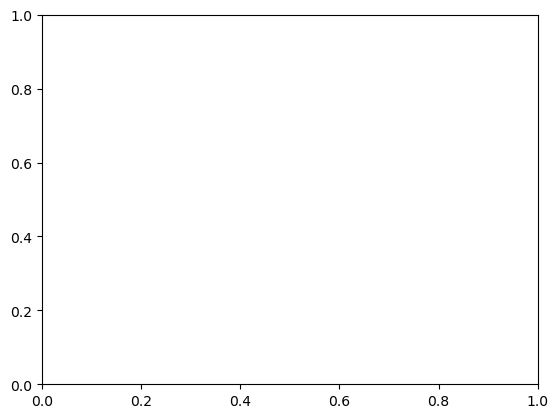

In [104]:
M_drama = characters_M[characters_M['Main genre'] == 'Drama']
M_drama_year = M_drama.groupby('date').count()
#plt.bar(M_drama_year.index, M_drama_year['name']/nb_year['movie_name'], label = 'M')

F_drama = characters_F[characters_F['Main genre'] == 'Drama']
F_drama_year = F_drama.groupby('date').count()
plt.bar(F_drama_year.index, F_drama_year['name']/nb_year['movie_name'], label = 'F')
plt.bar(F_drama_year.index, F_drama_year_norm, label = 'F')

#plt.bar(F_drama_year.index, M_drama_year['name'] - F_drama_year['name'], label = '\u0394')
plt.title('Drama')
plt.legend()
plt.show()

In [81]:
nb_year = movie_metadata.groupby('release_date').count()
nb_year = nb_year[(nb_year.index >= 1911) & (nb_year.index <= 2014)]

In [116]:
F_drama_year_norm = F_drama_year['name']/nb_year['movie_name']
F_drama_year_norm = F_drama_year_norm.fillna(0)
F_drama_year_norm

1911    0.021898
1912    0.000000
1913    0.000000
1914    0.010929
1915    0.040573
          ...   
2010    0.380129
2011    0.484649
2012    0.459799
2013    0.103659
2014    0.352941
Length: 104, dtype: float64

In [105]:
len(F_drama_year.index)

102

In [97]:
pd.Series(F_drama_year.index)

0      1911
1      1914
2      1915
3      1916
4      1917
       ... 
97     2010
98     2011
99     2012
100    2013
101    2014
Name: date, Length: 102, dtype: int64

In [106]:
len(F_drama_year_norm)

104

In [115]:
F_drama_year_norm

1911    0.021898
1912    0.000000
1913    0.000000
1914    0.010929
1915    0.040573
          ...   
2010    0.380129
2011    0.484649
2012    0.459799
2013    0.103659
2014    0.352941
Length: 104, dtype: float64

In [112]:
F_drama_year_norm.equals(F_drama_year.index)

False

In [117]:
nb_year

,movie_name,box_office,length,languages,country,genres
release_date,,,,,,
1911,137,0,51,137,137,137
1912,146,0,57,146,146,146
1913,272,0,74,272,272,272
1914,366,4,103,366,366,366
1915,419,1,98,419,419,419
...,...,...,...,...,...,...
2010,2023,329,1619,2023,2023,2023
2011,1824,310,1368,1824,1824,1824
2012,1194,158,610,1194,1194,1194


In [124]:
merged_charac[merged_charac['Main genre'] == 'Short Film']

,date,name,gender,age,genres,Main genre
movie_ID,,,,,,
17715326,1935,nan,M,NaN,[Short Film],Short Film
18109665,1915,nan,M,NaN,"[Short Film, Silent film, Drama, Black-and-white]",Short Film
18109665,1915,nan,F,NaN,"[Short Film, Silent film, Drama, Black-and-white]",Short Film
28028248,2010,nan,M,42.0,[Short Film],Short Film
21878654,2009,Jack Kahuna Laguna,M,45.0,[Short Film],Short Film
...,...,...,...,...,...,...
7762741,1914,nan,F,NaN,"[Short Film, Silent film, Drama]",Short Film
7762741,1914,nan,M,NaN,"[Short Film, Silent film, Drama]",Short Film
7762741,1914,nan,M,NaN,"[Short Film, Silent film, Drama]",Short Film


In [126]:
movie_metadata[movie_metadata.index == 7762741]

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
7762741,Business Versus Love,1914,NaN,NaN,[],[United States of America],"[Short Film, Silent film, Drama]"
